In [1]:
import os
import sys
import pickle
import numpy as np
import scipy as sc
from subprocess import call
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable, grad
import time
import numpy as np

In [3]:
batch_size = 64
data_length = batch_size*256
epochs = 100
seed = 1
lr = 0.001
momentum = 0.5
log_interval = 10
PATH = "model" # model path
cuda = torch.cuda.is_available()

if cuda:
    torch.cuda.manual_seed(seed)

In [4]:
def get_batch(n):
    # create some data
    X = np.random.rand(batch_size)
    np.random.shuffle(X)    # randomize the data
    Y = np.sin(5*np.pi*X)/(5*np.pi*X)
    X = torch.from_numpy(X).unsqueeze(1).float()
    Y = torch.from_numpy(Y).unsqueeze(1).float()
    return X, Y

In [5]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__() #load super class for training data
        self.fc1 = nn.Linear(1, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 1)

    def forward(self, x): #feed forward
        layer1 = self.fc1(x)
        layer2 = self.fc2(layer1)
        layer3 = self.fc3(layer2)
        return layer3

In [6]:
model = DNN()
if cuda:
    model.cuda()
print (model)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
print (optimizer)

DNN(
  (fc1): Linear(in_features=1, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=1, bias=True)
)


In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [8]:
print (count_parameters(model))

141


In [9]:
loss_history = []
miniratio_history = []
normgrad_history = []
cnt = 0

In [10]:
def train(epoch):
    model.train()
    for batch_idx in range(data_length//batch_size):
        data, target = get_batch(batch_size)
        if cuda:
            data, target = data.cuda(), target.cuda()
        
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, target)
        loss.backward()
        optimizer.step()
        
        #'''
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}  {}'.format(
                epoch, batch_idx * 256, data_length,
                100. * batch_idx / data_length, loss.data[0], len(loss_history)), end='\r')
        #'''

In [11]:
for epoch in range(epochs):
    train(epoch)

In [12]:
def cal_norm_grad(grad_params):
    grad_norm = 0
    for grad in grad_params:
        grad_norm += grad.pow(2).sum()
    grad_norm = grad_norm.sqrt()
    return grad_norm

In [13]:
def cal_miniratio(grads):
    flat_grad = torch.cat([g.view(-1) for g in grads])
    hessian = []
    
    for g in flat_grad:
        flat = np.array([])
        tmp = grad(g, model.parameters(), create_graph=True)
        tmp = [gg.data.cpu().numpy() for gg in tmp]
        for i in tmp:
            flat = np.concatenate((flat, np.ndarray.flatten(i)))
        hessian.append(flat)
    
    hessian = np.array(hessian)
    #print (hessian.shape)
    eigval = np.linalg.eigvalsh(hessian)
    
    cnt = 0
    for i in eigval:
        if i > 0:
            cnt += 1
    return cnt/len(eigval)

In [14]:
def train2(epoch):
    model.train()

    data, target = get_batch(data_length)
    if cuda:
        data, target = data.cuda(), target.cuda()

    data, target = Variable(data), Variable(target)
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward + backward + optimize
    output = model(data)
    loss = F.mse_loss(output, target)

    grads = grad(loss, model.parameters(), create_graph=True)
    grad_norm = cal_norm_grad(grads)
    if grad_norm.cpu().data[0] < 0.002:
        tmp = cal_miniratio(grads)
        miniratio_history.append(tmp)
        loss_history.append(loss.data[0])
    
    normgrad_history.append(grad_norm.data[0])
    grad_norm.backward()
    optimizer.step()

In [15]:
for epoch in range(epochs*200):
    train2(epoch)

In [16]:
print (len(normgrad_history), min(normgrad_history))

20000 0.0005828437278978527


In [17]:
print (len(miniratio_history))

11


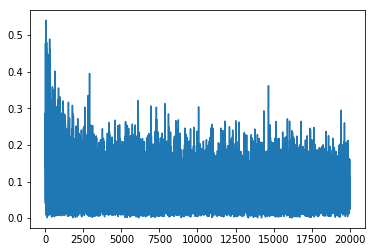

In [18]:
plt.clf()
plt.subplot(111)
e = list(range(len(normgrad_history)))
#print (np.array(e).shape, np.array(norm_grad_history).shape)
plt.plot(e, normgrad_history)

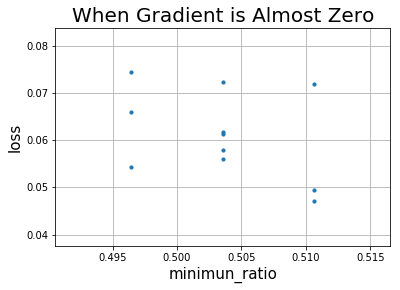

In [19]:
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_ylabel('loss', fontsize = 15)
ax.set_xlabel('minimun_ratio', fontsize = 15)
ax.set_title('When Gradient is Almost Zero', fontsize = 20)
ax.scatter(miniratio_history, loss_history, s = 10)
ax.grid()
plt.savefig('WhenGradientisAlmostZero.png')